# 09. Paper Replicating

##### Machine Learning Engineer:-
> 1. Download Research Paper
> 2. Replicate and implement it.
> 3. Keep doing until you have skills.


##### Paper Sources:-
> 1. [arXiv](https://arxiv.org/search/cs?query=machine+learning&searchtype=all&abstracts=show&order=-announced_date_first&size=50) - Pure paper archive.
> 2. [twitter](https://twitter.com/_akhaliq) - Account which shares latest news.
> 3. [GitHub - lucidrains](https://github.com/lucidrains/vit-pytorch) - They have turned research papers into coding examples.
> 4. [PapersWithCode](https://paperswithcode.com/) - Papers along with Code.

<img src="Paper_Replicating -1.png">

# 0. Get Setup

Let's import the code we have previously written and required libraries.

In [1]:
import torch
import torchvision
from helper_functions import set_seeds, download_data, plot_loss_curves
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'


## 1. Get Data

The whole goal of what we are trying to do is to replicate ViT architecture for our FoodVision Mini Problem.

To do that we need some data.

Namely... Pizza, Steak and Sushi images data.

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Dataset and DataLoaders

In [5]:
# Create Image Size
IMG_SIZE = 224     # Come from Table 3 of ViT Paper

# Create transform pipeline
manual_transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually Created Transform: {manual_transform}")


Manually Created Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
# Create a batch size of 128
BATCH_SIZE = 32

# Create DataLoaders
train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=manual_transform,
                                                                                batch_size=BATCH_SIZE,
                                                                                )

len(train_dataloaders), test_dataloaders, class_names

(8,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image 

As always, *visualize, visualize, visualize*

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloaders))

# Select a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

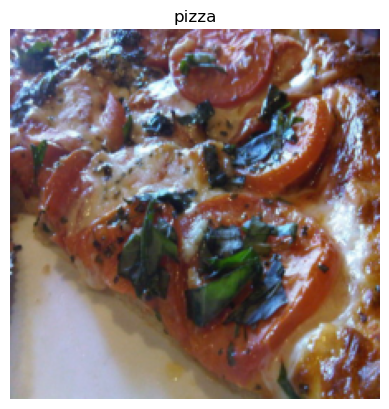

In [8]:
# plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole ML research paper can be intimidating.

So in order to make it more understandable, we break it down into smaller pieces.

* **Inputs** - What goes into the model? (in our case, image tensor)
* **Output** - What comes out of the model? (classification label in our case)
* **Layers** - Takes an input, manipulates it with a function (ex. Self-Attention).
* **Blocks** - A collection of layers.
* **Model or Architecture** - A collection of blocks.

<img src="Paper_Replicating -4.png">

### 3.1 ViT Overview: Pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: Math equations which define the functions of each layer.
* Table 1/3: Different hyperparameters for the architecture.
* Text

### Figure 1
<img src="Paper_Replicating -3.png">

* Embedding = Learnable representation (start with random numbers and improve overtime)

### Four Equations
<img src="Paper_Replicating -2.png">


#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ...image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..]
```
<img src="Paper_Replicating -6.png" width=600>

***

---
---
**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

Residual connection means adding input to functionized output x + fn(x)

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

<img src="Paper_Replicating -7.png" width=600>

---
--- 

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multi-layer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```
<img src="Paper_Replicating -8.png" width=600>

---
-----------

### Table 1
<img src="Paper_Replicating -5.png">

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* ViT-B/16 - ViT-Base with image path size 16x16
* Layers -  the number of transformer encoder layers.
* Hidden size $D$ - the embedding size throughout the architecture (Patched turned into vector size of ...)
* MLP size - the number of hidden units/neurons in the MLP. 
* Head -  the number of multi-head self-attention.

**These are hyperparameter settings.**

---

<img src="Paper_Replicating gif.gif">

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding.

Layers = input -> function -> output

What's the input shape?

What's the output shape?

### 4.1 Calculate input and output shape by hand

>**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

>**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$  
* Output shape: ${N\times\left(P^{2} \cdot C\right)}$
* H = height , W = width, C = color channels
* P = patch size 
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


In [9]:
# Create example values
height = 224
width = 224
color_channel = 3
patch_size = 16

# Calculate number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [10]:
# Input shape 
embedding_layer_input_shape = (height, width, color_channel)

# Output shape
embedding_layer_output_shape = (number_of_patches,  patch_size**2 * color_channel)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape(single 1D sequence of patches): {embedding_layer_output_shape}")

# (num_of_patches, embedding dimension)

Input shape (single 2D image): (224, 224, 3)
Output shape(single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

Let's *visualize, visualize, visualize...*

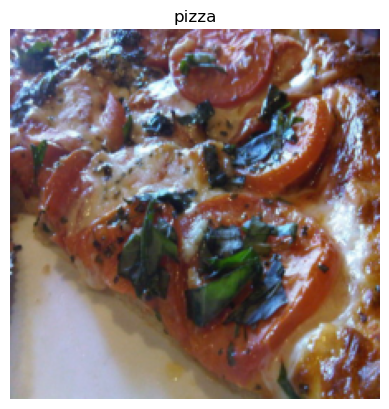

In [11]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [12]:
image.shape

torch.Size([3, 224, 224])

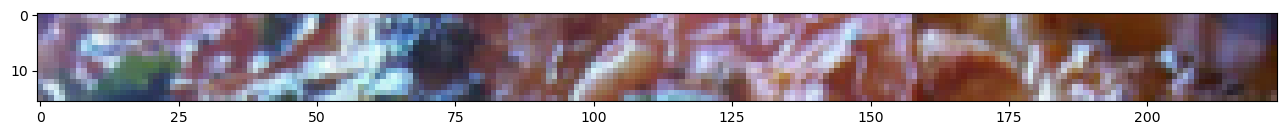

In [13]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)  # Doing this for matplotlib (h,w,c)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])


Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


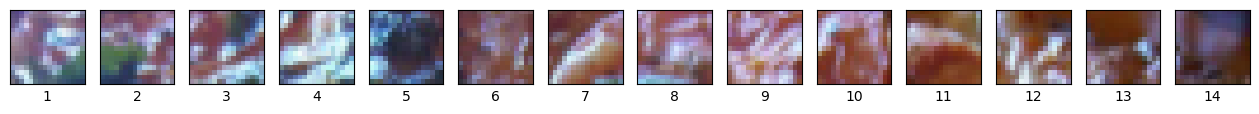

In [14]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, ax = plt.subplots(nrows=1, 
                       ncols=img_size // patch_size, #one column for each pathc
                      sharex=True,
                      sharey=True,
                      figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    ax[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    ax[i].set_xlabel(i+1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

NUmber of patches per row: 14.0     
Number of patches per column: 14.0     
Total Patches: 196.0     
Patch size: 16 pixels x 16 pixels


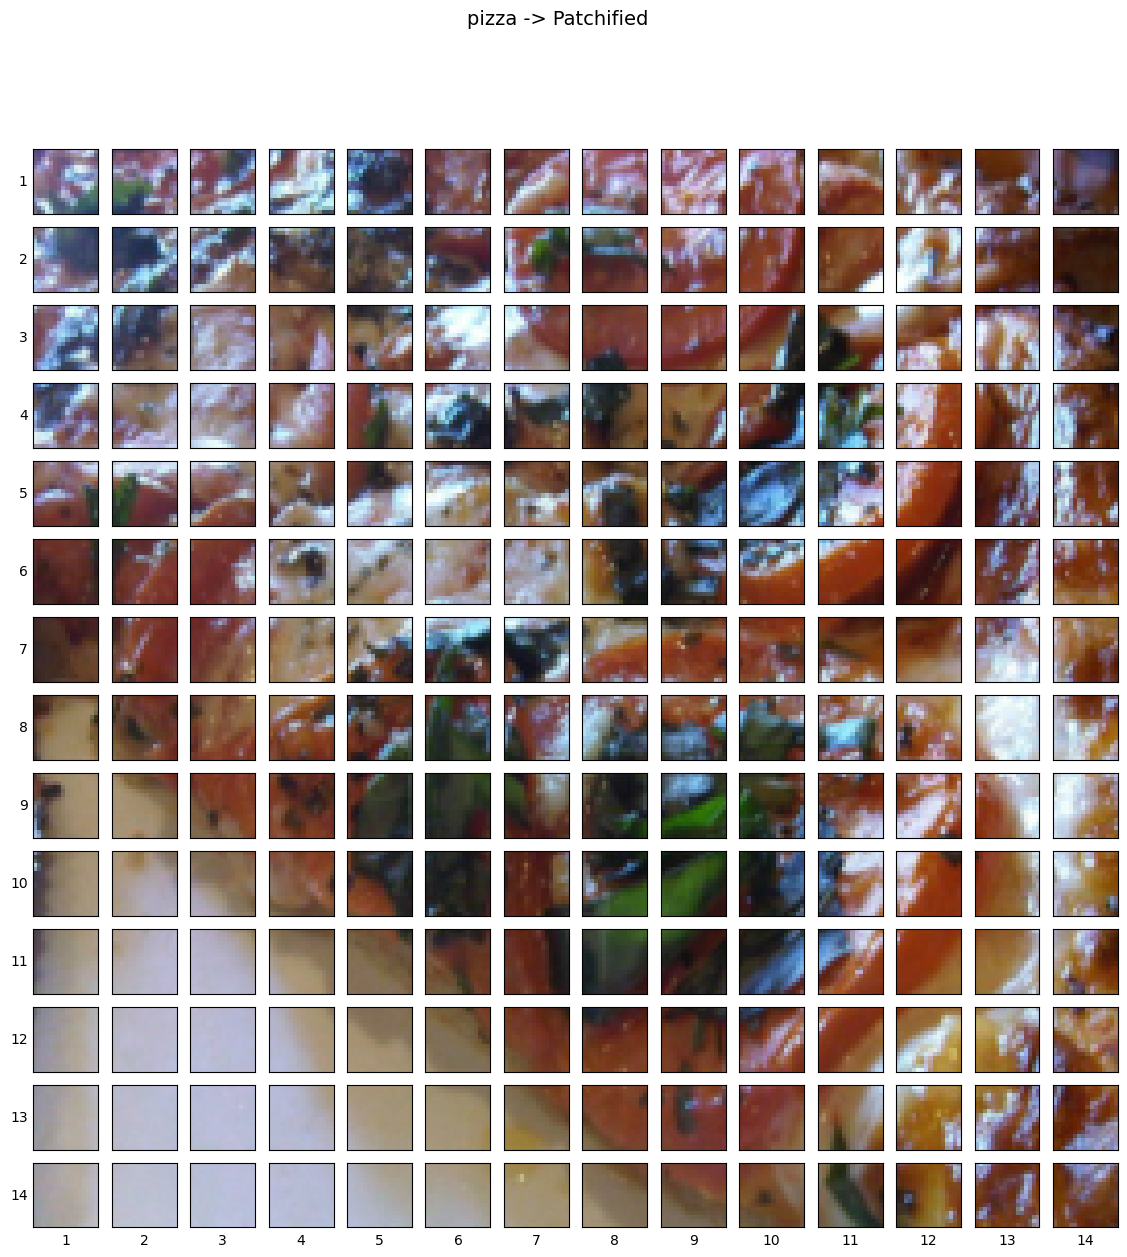

In [15]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"NUmber of patches per row: {num_patches} \
    \nNumber of patches per column: {num_patches} \
    \nTotal Patches: {num_patches*num_patches} \
    \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, ax = plt.subplots(nrows=img_size//patch_size,
                      ncols=img_size//patch_size,
                      figsize=(num_patches, num_patches),
                      sharex=True,
                      sharey=True)

# Loop through heigh and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):  #Iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image on different axes
        ax[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, #iterate through height
                                      patch_width:patch_width+patch_size, #iterate through width
                                      :])  # Get all color channels
        # Setup label information for each subplot (patch)
        ax[i,j].set_ylabel(i+1,
                          rotation="horizontal",
                          horizontalalignment="right",
                          verticalalignment="center")
        ax[i, j].set_xlabel(j+1)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].label_outer()
        
# Setup title for plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could crate the image patches and image patches embeddings in a single step using `torch.nn.Conv2d()` and settting the kernel size and stride equal to `patch_size`.


In [16]:
# Create conv2d layer to turn image into patcvhes of learnable feature maps

from torch import nn

# Set patch size
patch_size = 16

# Create a conv2d layer with hyperparamets from ViT Paper
conv2d = nn.Conv2d(in_channels=3,    #color channel
                  out_channels=768,  # D size from Table 1
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

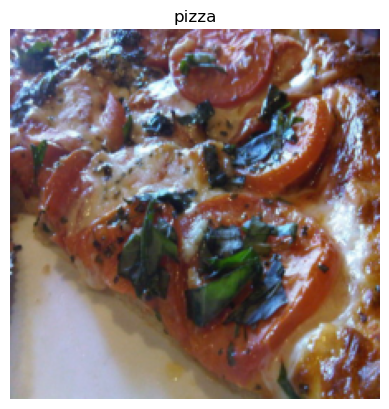

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add batch dimension = (N,C,H,W)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we have passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [222, 504, 199, 390, 238]


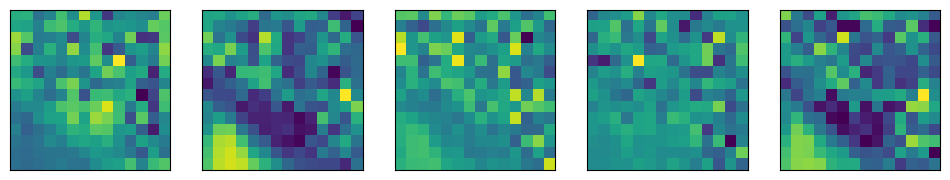

In [19]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")


# Create plot
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

#plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
    ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimesnsion, switch to numpy 
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0571, -0.0966, -0.2135, -0.3531, -0.0539, -0.0898,  0.0152,
           -0.0612, -0.1913, -0.1034, -0.0044,  0.0396, -0.0654, -0.0515],
          [ 0.0286, -0.0589, -0.0580, -0.1065, -0.0638, -0.0101, -0.0273,
           -0.0730, -0.1674, -0.1154, -0.0345, -0.1166, -0.1959, -0.0766],
          [ 0.0319, -0.1051, -0.0956, -0.0433, -0.0351, -0.1525, -0.1397,
           -0.0825, -0.1447, -0.0783, -0.0692, -0.2208,  0.0156, -0.0073],
          [-0.0504, -0.0760, -0.1287, -0.0896, -0.0483, -0.0859, -0.2118,
           -0.0568, -0.2345, -0.2584, -0.1276, -0.1210, -0.2745,  0.0808],
          [-0.1798, -0.2782, -0.1861, -0.0774, -0.1092, -0.1145, -0.0740,
            0.0574, -0.0305, -0.0295, -0.2026, -0.1095, -0.1979, -0.1323],
          [-0.1167, -0.0741, -0.0889, -0.2539, -0.1891, -0.1203, -0.0556,
           -0.0843, -0.1019, -0.2371, -0.1535, -0.1577, -0.0204, -0.1391],
          [-0.0804, -0.0962, -0.1556, -0.1771, -0.1119, -0.1010, -0.2422,
           -0.0653, -0.0236, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we have a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of ViT-Base

In [21]:
print(f"{image_out_of_conv.shape} -> [batch_size, embeddimg_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embeddimg_dim, feature_map_height, feature_map_width]


Want: (batch_size, number_of_pathches, embedding_dim)

In [22]:
flatten_layer = nn.Flatten(start_dim=2,   # we wanna flat feature_map_height
                          end_dim=-1)    # and feature_map_width

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original Image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


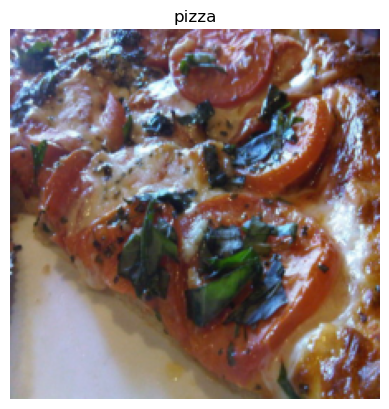

In [23]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original Image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) #add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dim)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)


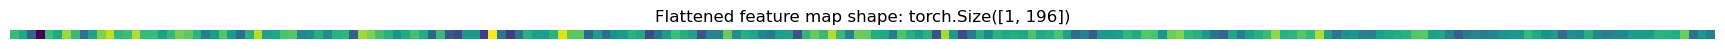

In [25]:
# Get a single feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class `PatchEmbedding`.
2. Initialize with appropriate hyperparameters such as channels, embedding dim and patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the out of the layer in 3.
5. Define a `forward()` that defines the forward computation.
6. Make sure the output shape of the layer reflects the required output shape of the embedding.

In [26]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable embedding vector.
    """
    # 2. Initialize the layer with appropriate hyperparameters
    def __init__(self, 
                 channels: int=3,
                 patch_size: int=16,
                 embedding_dimensions: int=768,  # from table 1 for ViT-Base
                 ):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a conv layer to turn an image into embedded patches
        self.patcher = nn.Conv2d(in_channels=channels,
                                   out_channels=embedding_dimensions,
                                   kernel_size=patch_size,
                                   stride=patch_size,
                                   padding=0)
        
        # 4. Create a layer to flatten the feature maps outputs of Conv2d
        self.flatter_layer = nn.Flatten(start_dim=2,
                                       end_dim=-1)
        
    # 5. Define a forward method to define the forward computation steps
    def forward(self, x):
        # Create assertion to check that inputs are in correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatter_layer(x_patched)
        # 6. Make sure the returned sequence embedding dim are in right order (batch_size, num_patch, embedding_dim)
        return x_flattened.permute(0, 2, 1)


In [27]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(channels=3,
                         patch_size=16,
                         embedding_dimensions=768)

# Passs a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))  # adding extra batch dim
print(f"Output patch emebedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch emebedding sequence shape: torch.Size([1, 196, 768])


**So far we have covered**

<img src="Paper_Replicating -9.png">

**Out Next Step**

<img src="Paper_Replicating -10.png">

### 4.6 Creating the class token embedding

Want to: Prepend a learnable class token to the start of patch embedding

In [28]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [29]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [30]:
# Create class token embedding as a leanable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

> We want to add the above dimension to each the dimension of `patch_embedded_image` = (1, 196, 768)

In [31]:
# Add the class_token embedding to the front of patch_embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                     dim=1)  # number_of_patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embedding with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim) ")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4967,  0.1987, -0.2336,  ...,  0.4225, -0.2848,  0.0193],
         [-0.5774,  0.2030,  0.0208,  ...,  0.3266, -0.3149, -0.0423],
         ...,
         [-0.3471,  0.2521, -0.0433,  ...,  0.3013, -0.2460, -0.0053],
         [-0.2570, -0.1179, -0.0068,  ...,  0.1697, -0.3319,  0.0347],
         [-0.5292,  0.0221,  0.0072,  ...,  0.2180, -0.2319,  0.1791]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim) 


**So far we have now added class_token to patch embedding**

<img src="Paper_Replicating -11.png">
<img src="Paper_Replicating -12.png">


### 4.7 Creating the position embedding

Want to: Create a series of 1D learnable embeddings and to add them the sequence of patch embeddings.
    
<img src="Paper_Replicating -13.png">

In [32]:
# View the sequence of patch embeddings with the prepend class embedding

patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4967,  0.1987, -0.2336,  ...,  0.4225, -0.2848,  0.0193],
          [-0.5774,  0.2030,  0.0208,  ...,  0.3266, -0.3149, -0.0423],
          ...,
          [-0.3471,  0.2521, -0.0433,  ...,  0.3013, -0.2460, -0.0053],
          [-0.2570, -0.1179, -0.0068,  ...,  0.1697, -0.3319,  0.0347],
          [-0.5292,  0.0221,  0.0072,  ...,  0.2180, -0.2319,  0.1791]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [33]:
# Calculate N(number_of_patches)
number_of_patches = int((height*width) / patch_size**2)


# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnavke 1D position embeding
position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                            embedding_dimension),
                                 requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [34]:
# View the sequence of patch embeddings with the prepend class embedding

patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4967,  0.1987, -0.2336,  ...,  0.4225, -0.2848,  0.0193],
          [-0.5774,  0.2030,  0.0208,  ...,  0.3266, -0.3149, -0.0423],
          ...,
          [-0.3471,  0.2521, -0.0433,  ...,  0.3013, -0.2460, -0.0053],
          [-0.2570, -0.1179, -0.0068,  ...,  0.1697, -0.3319,  0.0347],
          [-0.5292,  0.0221,  0.0072,  ...,  0.2180, -0.2319,  0.1791]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Add the position embedding to the patch and clas token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5033, 1.1987, 0.7664,  ..., 1.4225, 0.7152, 1.0193],
         [0.4226, 1.2030, 1.0208,  ..., 1.3266, 0.6851, 0.9577],
         ...,
         [0.6529, 1.2521, 0.9567,  ..., 1.3013, 0.7540, 0.9947],
         [0.7430, 0.8821, 0.9932,  ..., 1.1697, 0.6681, 1.0347],
         [0.4708, 1.0221, 1.0072,  ..., 1.2180, 0.7681, 1.1791]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


<img src="Paper_Replicating -14.png">

### 4.8 Putting it all together: From Image to Embedding

We've written code turn an image in a flattened sequence of patch embeddings.

In [36]:
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get the image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(channels=3,
                                       patch_size=patch_size,
                                      embedding_dimensions=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create Class_token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1 , embedding_dimension),
                          requires_grad=True)
print(f"Class Token Embedding Shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2 )
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                 requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding  = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class Token Embedding Shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


<img src="Paper_Replicating -15.png">

---
---
---

## Equation 2: Multihead Self-Attention (MSA block)

* Multihead self-attention:  which part of a sequence should pay the most attention to itself?
    * In our case, we have a series of embedded image patches, which patch significantly related to another patch.
    * we want out neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use this = https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm = Technique to normalize the distribution of intermediate layers. It enables smoother gradients, faster training and better generalization accuracy.
    * Normalization = make everything have same mean and same std
    * LayerNorm = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html , normalizes values over $D$ dimension, in our case, $D$ dimension is the embedding dimension.
        * When we normalize along the embedding dimension, it's like making all of the stairs in a stiarcase the same size.

<img src="Paper_Replicating -18.png">

Layer Norm gives three outputs = q, k, v

<img src="Paper_Replicating -16.png">

In [37]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """
    Creates a multihead self-attention block ("MSA block")
    """
    def __init__(self,
                embedding_dim: int=768,  # Hidden size D from table 1
                num_heads: int=12,   # Heads from Table 1
                attn_dropout:int=0):
        super().__init__()
        
        # Create the norm layer ()LN
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create multihead attention (MSA)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True) # is the batch first? (batch,seq,feature) -> (batch, num_of_patches, embedding_dim)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                            key=x,
                                            value=x,
                                            need_weights=False)
        return attn_output

In [38]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                            num_heads=12,
                                                            attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


<img src="Paper_Replicating -19.png">

---
---
---

## 6. Equation 3: Multilayer Perceptron (MLP Block)

* **MLP** = The MLP contains two layer with GELU non-linearity.
    * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
    * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in Tensorflow called `tf.keras.dense.layer()`
    * MLP number of hidden units = MLP size in Table 1
* **Dropout** = Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
    * Value for dropout available in table 3
    
In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

<img src="Paper_Replicating -20.png">

In [39]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim: int=768,
                mlp_size:int = 3072,
                dropout:float =0.1):
        super().__init__()
        
        # Create norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                     out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                     out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x))  #same as above

In [40]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                    mlp_size=3072,
                    dropout=0.1)

# Pass output of MSA Block through MLP Block
patched_image_through_MLP_block = mlp_block(patched_image_through_msa_block)

print(f"Input shape of MSA Block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP Block: {patched_image_through_MLP_block.shape}")

Input shape of MSA Block: torch.Size([1, 197, 768])
Output shape of MLP Block: torch.Size([1, 197, 768])


<img src="Paper_Replicating -21.png">

---
---
---

## 7. Creating the Transformer Encode

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).


And there is residual connections between each block.

* Encoder = turns a sequence into a learnable representation.
* Decoder = turns a learnable reprentation into a sequence.
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode-

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP Block -> [MLP_block_output + MSA_block_ouput + x_input] -> ...

```

### 7.1 Custom a custom Trasnformer Encoder Block

In [41]:
class  TransformerEncoderBlock(nn.Module):
    def __init__(self,
                embedding_dim: int=768,   # Hidden size D from table 1
                num_heads:int=12,         # From Table 1
                attn_dropout:int=0,       
                mlp_size: int=3072,       # From Table 1
                mlp_dropout:float =0.2):      # From table 3
        super().__init__()
        
        # Create MSA Block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    attn_dropout=attn_dropout)
        
        # Create MLP Block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                 mlp_size=mlp_size,
                                 dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x    #residual connection for equation 2
        x = self.mlp_block(x) + x    # residual connection for equation 3 
        return x

In [42]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
       input_size=(1, 197, 768),  #(batch_size, number_of_patches, embedding_dim)
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

<img src="Paper_Replicating -22.png">

### 7.2 Create a transformer Encoder Layer with inbuilt PyTorch Layers

So far we've created a trasnfoerm encoder by hand.

But because of how good the Transform architecture is, PyTorch has in-built Transformer Encoder Layers: https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transfoermer Encoder with Pure Pytorch layers

In [43]:
# Create the same as above with torch.nn.TransformerEncoderLayer

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, #embedding size
                                                            nhead=12,     # heads from table 1
                                                            dim_feedforward=3072, #MLP size 
                                                            dropout=0.1,
                                                            activation='gelu',
                                                            batch_first=True,
                                                            norm_first=True  #LayerNorm done first
                                                            )

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [44]:
summary(model=torch_transformer_encoder_layer,
       input_size=(1, 197, 768),  #(batch_size, number_of_patches, embedding_dim)
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

> Why spend all this time recreating the transformer encoder when we could've just made it with single PyTorch code?

> Practice. Practice. Practice.

> Now we know how things are implemented behind the scenes. We can tweak them if necessary.

> What are the benefits of using a pre-built PyTorch layer?

> * Less prone to errors
> * Potential benefit of speedups (performance boost) | Faster Inference Time

## 8. Putting it all together to create ViT

In [46]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dimensions=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [47]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of our ViT with the number of classes we're working with 

vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT isntance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [48]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
       input_size=(1, 3, 224, 224),  #(batch_size, color_channels, height, width)
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatter_layer)                               [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT

WE've replicated the ViT architecture now let's see how it performs on our FoodVision Mini Data.

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & Fine-Tuning) with $B1$ value of 0.9, $B2$ value of 0.999 and weight decay of 0.1.

Weight Decay = It is a regularization technique applied to the weights of a neural network.

Regularization Technique prevents overfitting.

In [50]:
optimizer = torch.optim.Adam(vit.parameters(),
                            lr=1e-3,
                            betas=(0.9, 0.999),
                            weight_decay=0.1)

### 9.2 Creating a loss function

The ViT doesn't actually mentioned what loss functiomn they usd.

Since it's a multi-class classification, we'll use the `torch.nn.CrossEntropyLoss`

In [51]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [64]:
from going_modular import engine

set_seeds()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

results = engine.train(model=vit.to(device),
                      train_dataloader=train_dataloaders,
                      test_dataloader=test_dataloaders,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device=device)

cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8672 | train_acc: 0.3008 | test_loss: 1.0567 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.4722 | train_acc: 0.3047 | test_loss: 1.4178 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.3983 | train_acc: 0.2656 | test_loss: 1.4212 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2459 | train_acc: 0.4180 | test_loss: 2.0115 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3166 | train_acc: 0.2812 | test_loss: 1.5513 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2517 | train_acc: 0.3008 | test_loss: 1.6530 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1901 | train_acc: 0.4102 | test_loss: 3.3314 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.5223 | train_acc: 0.2695 | test_loss: 1.2907 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2961 | train_acc: 0.3086 | test_loss: 1.2106 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3369 | train_acc: 0.3086 | test_loss: 1.2652 | test_acc: 0.2604


### 9.4 What our training setup is missing?

How is our training setup different from ViT paper?

We've replicated the model architecture correctly.

One major reason is SCALE.

<img src="Paper_Replicating -23.png">

Prevent Underfitting:
* Data - out setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup -  start from low and inscreate to base LR
* Learning rate decay - as you model gets closer to convergence, start to lower the leaning rate.
* Gradient Clipping - prevent gradients from getting too big

### 9.5 Plotting loss curves for our model

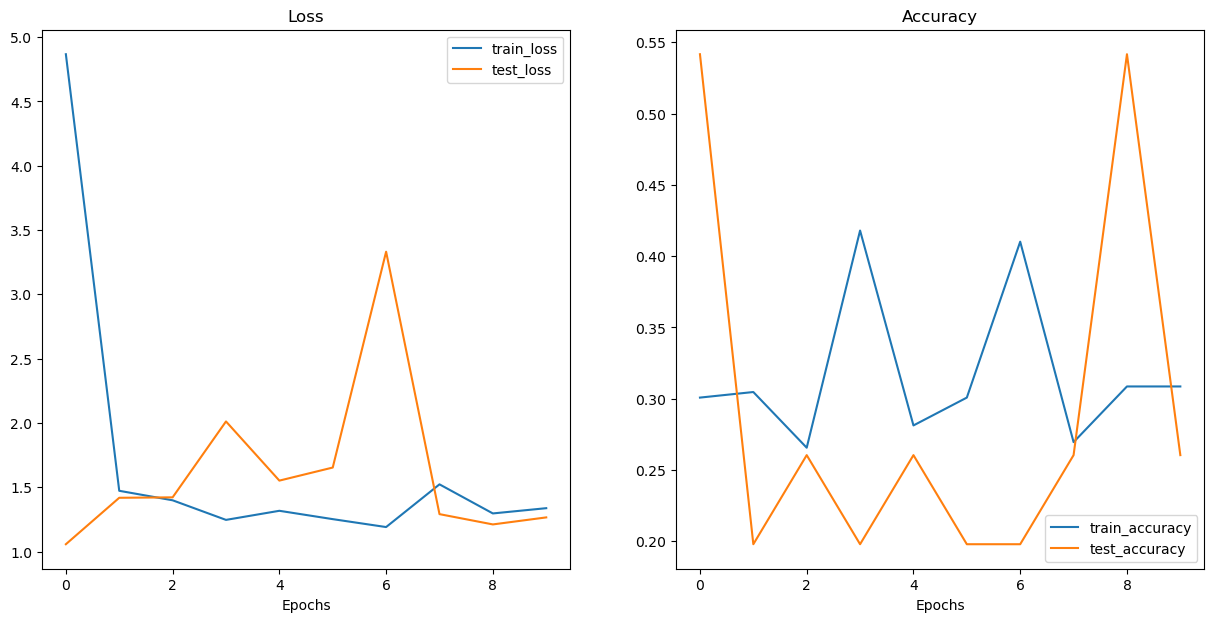

In [65]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

Our model is overfitting and underfitting at same time!

## 10. Using a pretrained ViT from `torchvision.models`

Generally in deep leanring, if you can use a pretrained model froma a large dataset on your own problem, it's often a good place to start.

### 10.1 Why use Pretrained model?

**Why use a pretrianed model?**

* Get better results faster (sometime)
* Limited training resources
* Data is limited

In [74]:
import torch 
import torchvision
print(torch.__version__, torchvision.__version__)

2.0.0 0.15.0


In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini

In [88]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with rpetrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Update classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                out_features=len(class_names)).to(device)

In [89]:
from torchinfo import summary

summary(model=pretrained_vit,
       input_size=(1, 3, 224, 224),  #(batch_size, color_channels, height, width)
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pre-trained ViT model

When using a pretrained model, you want to make sure your data is formatted in same way the model was trained on.

In [90]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [91]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32             #could set a higher batch size coz we using pretrained
)

train_dataloader_pretrained, test_dataloader_pretrained,class_names

(<torch.utils.data.dataloader.DataLoader at 0x25d2a1ac340>,
 ['pizza', 'steak', 'sushi'])

### 10.4 Train feature extractor ViT model

In [92]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                            lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

# Train the classfier head of pretrained ViT
set_seeds()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                     train_dataloader=train_dataloader_pretrained,
                                     test_dataloader=test_dataloader_pretrained,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=10,
                                     device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


### 10.5 Plot the loss curve of our pretrained ViT feature extractor model

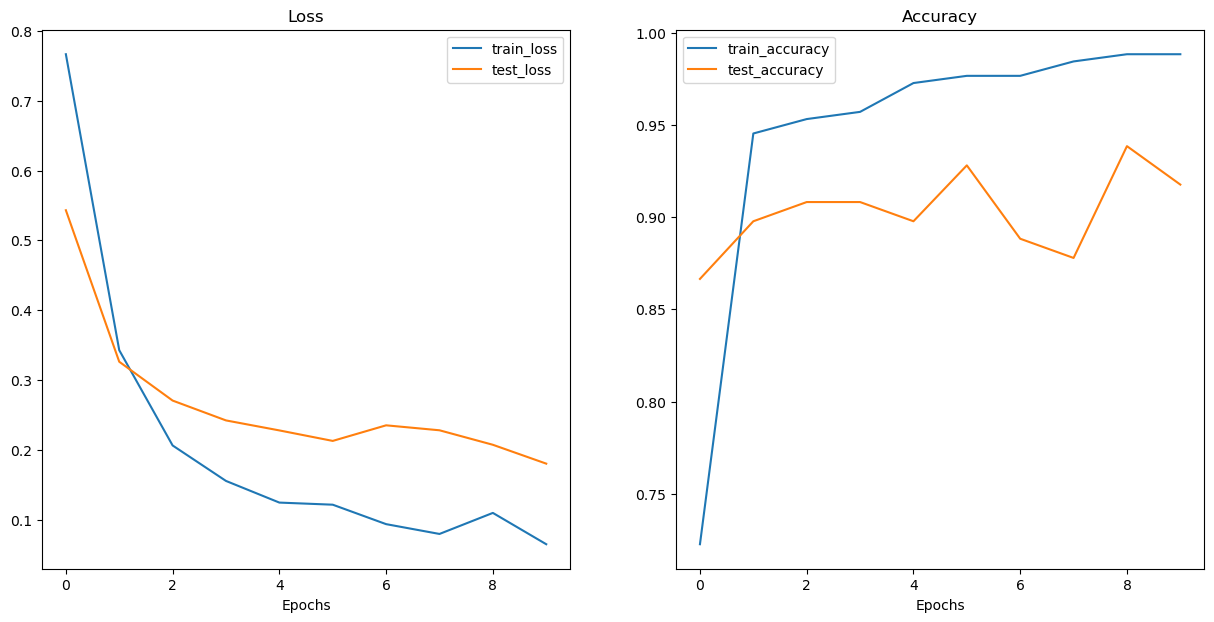

In [93]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite well, how about we save it to file and check its file size

We want to check the file size becoz if we want to deploy a model to website/mobile app, we may have limitations on the size of the model we can deploy.

In [95]:
# Save the model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                target_dir="models",
                model_name="09_pretrained_vit_feature_extractor.pth")


[INFO] Saving model to: models\09_pretrained_vit_feature_extractor.pth


In [98]:
from pathlib import Path

# Get the model size in bytes then we will convert it to MB
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor.pth").stat().st_size // (1024*1024)

print(f"Pretrained ViT feature extractor size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor size: 327 MB


Model size is ~11x larger than our next best performing model.

Perhaps the larger model size might cause issue when we deploy as it will give slower predictions.

## 11. Predicting on a custom image

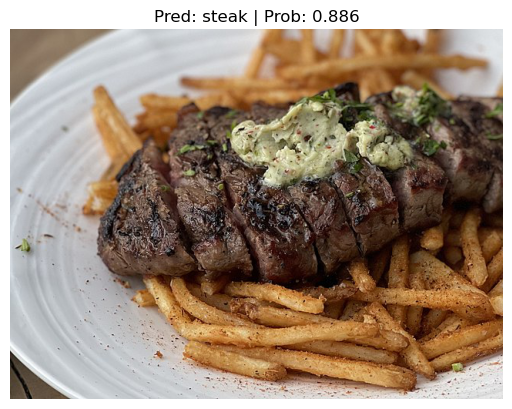

In [99]:
from going_modular import predictions

predictions.pred_and_plot_image(model=pretrained_vit,
                               image_path="steak.jpg",
                               class_names=class_names)